# pH Classification - Feature Selection Using Extra Trees Classifier

In [1]:
import pandas as pd
import numpy as np

In [2]:
phDf = pd.read_csv('C:/Users/Nefeli/Desktop/biomed_project_data/phDf_bin.csv')

In [3]:
#to_drop=['FHR_I_ffill_haar_shan_entr','FHR_II_ffill_haar_shan_entr']
#phDf= phDf.drop(columns=to_drop).copy()

#Prep dataframe
phDf.replace([np.inf, -np.inf], np.nan, inplace=True)
phDf.dropna(inplace=True)
phDf = phDf.reset_index(drop=True)
phDf.shape

(221, 53)

In [4]:
target = ['pH_risk']
X = phDf.drop(target, axis=1).copy()
y =phDf[target].copy()

In [5]:
y_labels, counts = np.unique(y['pH_risk'], return_counts=True)
print(y_labels)
print(counts)

['NORISK' 'RISK']
[114 107]


In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y['pH_risk'].ravel())
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping:")
print(label_mapping)

Mapping:
{'NORISK': 0, 'RISK': 1}


#### Feature Selection with ExtraTreesClassifier and SelectFromModel 

In [7]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel 

clf = ExtraTreesClassifier(n_estimators=10)
clf = clf.fit(X, y['pH_risk'].ravel())
#clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X_red = model.transform(X)
X_red.shape  

C:\Users\Nefeli\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(221, 7)

In [8]:
# Set feature names explicitly
X_red_named = pd.DataFrame(X_red, columns=X.columns[model.get_support()])

# Print the shape of the transformed data
print("Shape of transformed X:", X_red_named.shape)
X_red_named.columns

Shape of transformed X: (221, 7)


Index(['BDecf', 'pCO2', 'BE', 'Apgar1', 'Apgar5', 'Rec.type',
       'FHR_II_ffill_sdnn'],
      dtype='object')

### Imports For Models:

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap 
import xgboost
import matplotlib.pylab as plt

### K-NN

#### Train and Fit

In [10]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_red_named, y_encoded.ravel(), test_size=0.2, random_state=42)

num_nb = 20 # num of neighbors

#train and fit 
knn_clf = KNeighborsClassifier(n_neighbors=num_nb)
fitted_knn=knn_clf.fit(np.ascontiguousarray(X_train), y_train)
y_pred = knn_clf.predict(np.ascontiguousarray(X_test))

# get accruacy
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_report_str}')


Accuracy: 0.8222222222222222
Confusion Matrix:
[[18  3]
 [ 5 19]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        21
           1       0.86      0.79      0.83        24

    accuracy                           0.82        45
   macro avg       0.82      0.82      0.82        45
weighted avg       0.83      0.82      0.82        45



#### ROC 

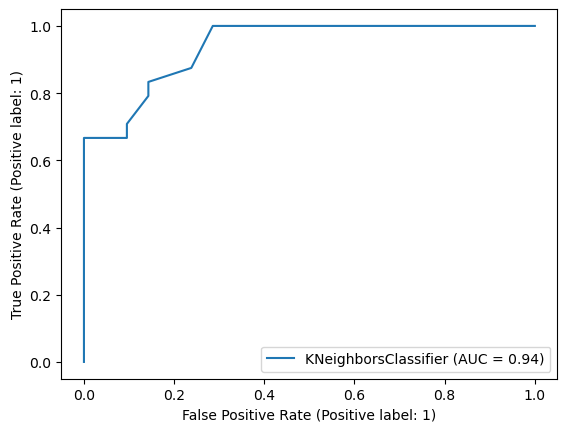

In [11]:
knn_disp = RocCurveDisplay.from_estimator(fitted_knn , np.ascontiguousarray(X_test), y_test)
plt.show()

#### K-fold Cross Validation for K = 5

In [12]:
X_red_named_knn = np.ascontiguousarray(X_red_named)
cross_val_scores_acc = cross_val_score(knn_clf, X_red_named_knn, y_encoded,  scoring= 'accuracy')
print("Accuracy for all folds: ", cross_val_scores_acc)
print("Mean Accuracy: ", cross_val_scores_acc.mean())

cross_val_scores_f1 = cross_val_score(knn_clf, X_red_named_knn, y_encoded,  scoring= 'f1')
print("F1 Score for all folds: ", cross_val_scores_f1)
print("Mean F1 Score: ", cross_val_scores_f1.mean())


cross_val_scores_pr = cross_val_score(knn_clf, X_red_named_knn, y_encoded,  scoring= 'precision')
print("Precision for all folds: ", cross_val_scores_pr)
print("Mean Precision: ", cross_val_scores_pr.mean())


cross_val_scores_r = cross_val_score(knn_clf, X_red_named_knn, y_encoded,  scoring= 'recall')
print("Recall for all folds: ", cross_val_scores_pr)
print("Mean Recall: ", cross_val_scores_pr.mean())

Accuracy for all folds:  [0.84444444 0.86363636 0.81818182 0.79545455 0.84090909]
Mean Accuracy:  0.8325252525252524
F1 Score for all folds:  [0.82051282 0.85       0.78947368 0.76923077 0.82051282]
Mean F1 Score:  0.8099460188933871
Precision for all folds:  [0.94117647 0.94444444 0.88235294 0.83333333 0.88888889]
Mean Precision:  0.8980392156862745
Recall for all folds:  [0.94117647 0.94444444 0.88235294 0.83333333 0.88888889]
Mean Recall:  0.8980392156862745


### Random Forest Classifier

#### Train and Fit 

In [13]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_red_named, y_encoded.ravel(), test_size=0.2, random_state=42)

#train and fit
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)
fitted_rf = rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

# get accuracy and metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)


print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_report_str}')


Accuracy: 0.9777777777777777
Confusion Matrix:
[[20  1]
 [ 0 24]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.96      1.00      0.98        24

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



#### ROC

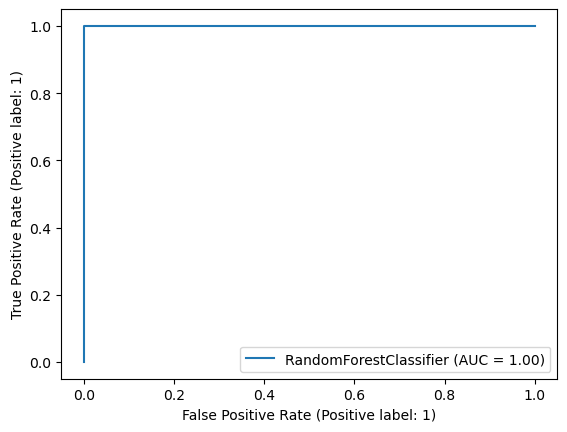

In [14]:
rf_disp = RocCurveDisplay.from_estimator(fitted_rf , X_test, y_test)
plt.show()

#### K-fold Cross Validation for K = 5

In [15]:
cross_val_scores_acc = cross_val_score(rf_clf, X_red_named, y_encoded,  scoring= 'accuracy')
print("Accuracy for all folds: ", cross_val_scores_acc)
print("Mean Accuracy: ", cross_val_scores_acc.mean())

cross_val_scores_f1 = cross_val_score(rf_clf, X_red_named, y_encoded,  scoring= 'f1')
print("F1 Score for all folds: ", cross_val_scores_f1)
print("Mean F1 Score: ", cross_val_scores_f1.mean())


cross_val_scores_pr = cross_val_score(rf_clf, X_red_named, y_encoded,  scoring= 'precision')
print("Precision for all folds: ", cross_val_scores_pr)
print("Mean Precision: ", cross_val_scores_pr.mean())


cross_val_scores_r = cross_val_score(rf_clf, X_red_named, y_encoded,  scoring= 'recall')
print("Recall for all folds: ", cross_val_scores_pr)
print("Mean Recall: ", cross_val_scores_pr.mean())

Accuracy for all folds:  [0.97777778 0.93181818 0.95454545 0.95454545 0.95454545]
Mean Accuracy:  0.9546464646464645
F1 Score for all folds:  [0.97674419 0.93617021 0.95238095 0.95238095 0.95238095]
Mean F1 Score:  0.9540114511910653
Precision for all folds:  [1.         0.88       0.95238095 0.95238095 0.95238095]
Mean Precision:  0.9474285714285715
Recall for all folds:  [1.         0.88       0.95238095 0.95238095 0.95238095]
Mean Recall:  0.9474285714285715


## XGBoost Classifier 

#### Train and Fit 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_red_named, y_encoded, test_size=0.2)
xg_clf = xgboost.XGBClassifier()
fitted_xg = xg_clf.fit(X_train, y_train)
y_pred = xg_clf.predict(X_test)

# get accuracy and metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)


print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_report_str}')

Accuracy: 0.9555555555555556
Confusion Matrix:
[[22  2]
 [ 0 21]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        24
           1       0.91      1.00      0.95        21

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



#### ROC 

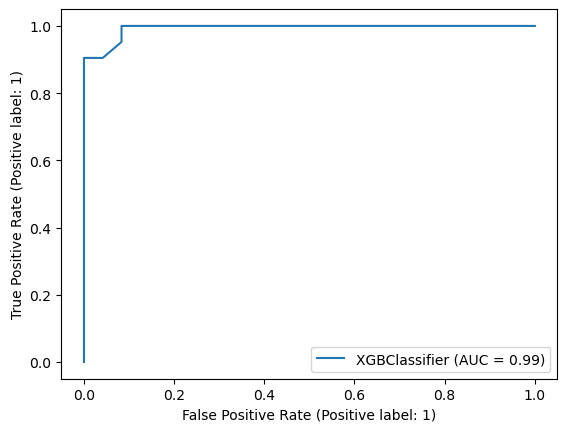

In [17]:
rf_disp = RocCurveDisplay.from_estimator(fitted_xg , X_test, y_test)
plt.show()

#### K-fold Cross Validation for K = 5

In [18]:
cross_val_scores_acc = cross_val_score(xg_clf, X_red_named, y_encoded,  scoring= 'accuracy')
print("Accuracy for all folds: ", cross_val_scores_acc)
print("Mean Accuracy: ", cross_val_scores_acc.mean())

cross_val_scores_f1 = cross_val_score(xg_clf, X_red_named, y_encoded,  scoring= 'f1')
print("F1 Score for all folds: ", cross_val_scores_f1)
print("Mean F1 Score: ", cross_val_scores_f1.mean())


cross_val_scores_pr = cross_val_score(xg_clf, X_red_named, y_encoded,  scoring= 'precision')
print("Precision for all folds: ", cross_val_scores_pr)
print("Mean Precision: ", cross_val_scores_pr.mean())


cross_val_scores_r = cross_val_score(xg_clf, X_red_named, y_encoded,  scoring= 'recall')
print("Recall for all folds: ", cross_val_scores_pr)
print("Mean Recall: ", cross_val_scores_pr.mean())

Accuracy for all folds:  [1.         0.97727273 0.95454545 0.97727273 0.95454545]
Mean Accuracy:  0.9727272727272727
F1 Score for all folds:  [1.         0.97777778 0.95238095 0.97674419 0.95238095]
Mean F1 Score:  0.9718567737172389
Precision for all folds:  [1.         0.95652174 0.95238095 0.95454545 0.95238095]
Mean Precision:  0.9631658196875588
Recall for all folds:  [1.         0.95652174 0.95238095 0.95454545 0.95238095]
Mean Recall:  0.9631658196875588


### Exploring Feature Importance in the XGBoost Classifier implementation using the SHAP library 

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html

<Figure size 10000x480 with 0 Axes>

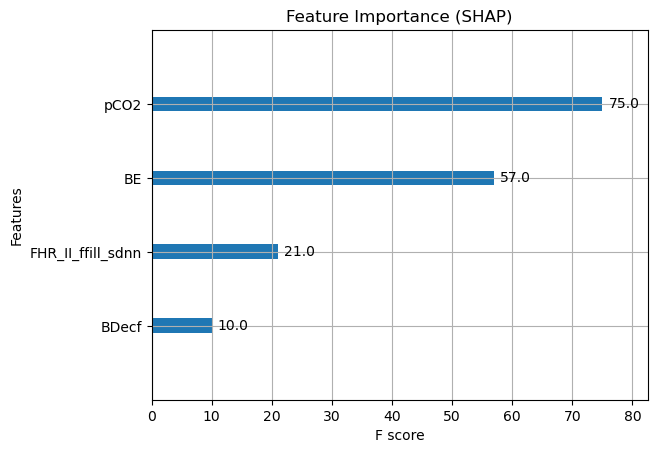

In [19]:
plt.figure().set_figwidth(100)
xgboost.plot_importance(xg_clf)

plt.title("Feature Importance (SHAP)")
plt.show()


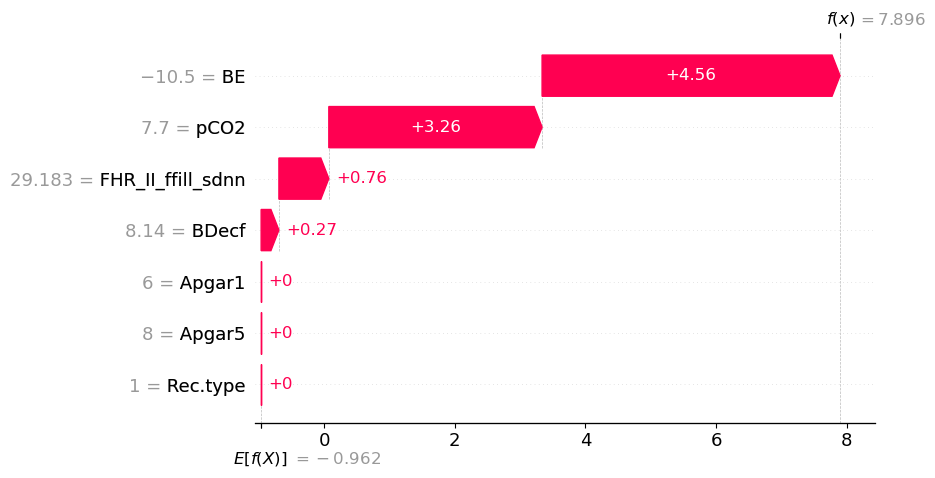

In [20]:
explainer = shap.Explainer(xg_clf, X_red_named)
shap_values = explainer(X_red_named)
shap.plots.waterfall(shap_values[0])